Internet use and religion in Europe, part three
-----------------------------------------

This notebook presents explorations of the association between Internet use and religion in Europe, using data from the European Social Survey (http://www.europeansocialsurvey.org).

Copyright 2015 Allen Downey

MIT License: http://opensource.org/licenses/MIT

In [100]:
from __future__ import print_function, division

import string
import random

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

import thinkstats2
import thinkplot
import matplotlib.pyplot as plt

import ess

%matplotlib inline

Read all data

In [29]:
%time cycles = ess.read_all_cycles()

CPU times: user 13.9 s, sys: 1.58 s, total: 15.4 s
Wall time: 15.4 s


Clean the data

In [32]:
for cycle in cycles:
    %time ess.clean_cycle(cycle)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 11.2 ms
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 9.02 ms
CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 8.55 ms
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 9.56 ms
CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 9.35 ms


Resample

In [33]:
%time cycle_maps = [ess.resample(cycle) for cycle in cycles]
for cycle_map in cycle_maps:
    print(len(cycle_map), 'countries')

CPU times: user 336 ms, sys: 52 ms, total: 388 ms
Wall time: 388 ms
22 countries
25 countries
23 countries
29 countries
27 countries


Remove a few countries from a few cycles where they are missing data.

In [34]:
%time ess.remove_missing(cycle_maps)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 574 µs


Replace income and education with ranks

In [35]:
for cycle_map in cycle_maps:
    %time ess.replace_with_ranks(cycle_map)

CPU times: user 148 ms, sys: 0 ns, total: 148 ms
Wall time: 147 ms
CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 162 ms
CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 160 ms
CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 248 ms
CPU times: user 200 ms, sys: 0 ns, total: 200 ms
Wall time: 201 ms


Fill missing values

In [36]:
for cycle_map in cycle_maps:
    %time ess.fill_vars_by_country(cycle_map)

CPU times: user 280 ms, sys: 84 ms, total: 364 ms
Wall time: 365 ms
CPU times: user 296 ms, sys: 100 ms, total: 396 ms
Wall time: 396 ms
CPU times: user 284 ms, sys: 116 ms, total: 400 ms
Wall time: 402 ms
CPU times: user 384 ms, sys: 116 ms, total: 500 ms
Wall time: 502 ms
CPU times: user 356 ms, sys: 120 ms, total: 476 ms
Wall time: 478 ms


Contatenate the countries within each cycle

In [38]:
%time dfs = [ess.concat_groups(cycle_map) for cycle_map in cycle_maps]
for df in dfs:
    print(len(df))

CPU times: user 72 ms, sys: 16 ms, total: 88 ms
Wall time: 88.2 ms
37937
43709
43000
56752
52458


Contatenate the cycles

In [39]:
%time df = pd.concat(dfs, ignore_index=True)
print(df.shape)

CPU times: user 16 ms, sys: 12 ms, total: 28 ms
Wall time: 24.9 ms
(233856, 32)


Group by country

In [15]:
grouped = df.groupby('cntry')
len(grouped)

34

The previous steps are now in two functions.  The first reads and cleans the data:

In [40]:
%time cycles = ess.read_and_clean()

The second resamples and fills

In [44]:
%time df = ess.resample_and_fill(cycles)

resampling
removing
replacing
Round 1
HU hinctnta
IE hinctnta
Round 2
EE hinctnta
UA hinctnta
Round 3
HU hinctnta
EE hinctnta
UA hinctnta
Round 4
BG hinctnta
CY hinctnta
SK hinctnta
Round 5
PT hinctnta
filling
concating
CPU times: user 3 s, sys: 628 ms, total: 3.62 s
Wall time: 3.64 s


I run the resampling process a few hundred times and store the results in HDF

In [45]:
store = pd.HDFStore('ess.resamples.h5')

It's pretty fast, considering the size of these DataFrames.


In [46]:
%time store.put('df', df)

CPU times: user 124 ms, sys: 56 ms, total: 180 ms
Wall time: 182 ms


In [48]:
%time df = store.get('df')

CPU times: user 32 ms, sys: 24 ms, total: 56 ms
Wall time: 54.5 ms


I store the dataframe using random keys.

In [91]:
def random_name():
    t = [random.choice(string.ascii_letters) for i in range(6)]
    return ''.join(t)

random_name()

'KzFWeo'

Add dataframes to the store

In [378]:
def add_frames(n):
    for i in range(n):
        name = random_name()
        print(name)
        df = ess.resample_and_fill(cycles)
        store.put(name, df)

How many dataframes in the store?

In [379]:
keys = store.keys()
len(keys)

204

Pick one at random

In [199]:
key = random.choice(keys)
df = store.get(key)

And run the logit model

In [201]:
formula = ('hasrelig_f ~ inwyr07_f + yrbrn60_f + edurank_f + hincrank_f +'
           'tvtot_f + rdtot_f + nwsptot_f + netuse_f')
res = ess.run_model(df, formula)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             hasrelig_f   No. Observations:               233856
Model:                          Logit   Df Residuals:                   233847
Method:                           MLE   Df Model:                            8
Date:                Wed, 18 Nov 2015   Pseudo R-squ.:                 0.03130
Time:                        13:25:33   Log-Likelihood:            -1.4810e+05
converged:                       True   LL-Null:                   -1.5289e+05
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.1474      0.017     68.390      0.000         1.114     1.180
inwyr07_f      0.0511      0.002     32.995      0.000         0.048     0.054
yrbrn60_f     -0.0084      0.000    -30.239      0.000        -0.009    -0.008
edurank_f     -0.0107      0.017     -0.631      0.528        -0.044     0.023
hincrank_f     0.0810      0.016      5.093      0.000         0.050     0.112
tvtot_f       -0.0200      0.002     -8.940      0.000        -0.024    -0.016
rdtot_f       -0.0158      0.002     -9.419      0.000        -0.019    -0.013
nwsptot_f     -0.0317      0.004     -8.825      0.000        -0.039    -0.025
netuse_f      -0.1130      0.002    -64.205      0.000        -0.116    -0.110
==============================================================================
"""

I use Country objects to collect data associated with each country.

In [318]:
class Country:
    def __init__(self, code, nobs):
        self.code = code
        self.name = ess.country_name(code)
        self.nobs = nobs
        self.mean_map = {}
        self.param_map = {}

    def add_mean(self, means):
        self.mean_seq.append(means)
        
    def add_params(self, params):
        self.param_seq.append(params)
        
    def add_params2(self, params):
        self.param2_seq.append(params)
        
    def get_means(self, varname):
        t = [mean[varname] for mean in self.mean_seq]
        return np.array(t)

    def get_params(self, varname):
        t = [params[varname] for params in self.param_seq]
        return np.array(t)

    def get_params2(self, varname):
        t = [params[varname] for params in self.param2_seq]
        return np.array(t)

Make the country objects

In [290]:
keys = store.keys()
key = random.choice(keys)
df = store.get(key)

grouped = df.groupby('cntry')
country_map = {}

for code, group in grouped:
    country_map[code] = Country(code, len(group))
    print(country_map[code].name)

Austria
Belgium
Bulgaria
Switzerland
Cyprus
Czech Republic
Germany
Denmark
Estonia
Spain
Finland
France
United Kingdom
Greece
Croatia
Hungary
Ireland
Israel
Iceland
Italy
Lithuania
Luxembourg
Latvia
Netherlands
Norway
Poland
Portugal
Romania
Russia
Sweden
Slovenia
Slovakia
Turkey
Ukraine


For each resampled frame, run both models and store the results in the Country objects

In [291]:
formula1 = ('hasrelig_f ~ inwyr07_f + yrbrn60_f + '
            'edurank_f + hincrank_f +'
            'tvtot_f + rdtot_f + nwsptot_f + netuse_f')

formula2 = ('rlgdgr_f ~ inwyr07_f + yrbrn60_f + '
            'edurank_f + hincrank_f +'
            'tvtot_f + rdtot_f + nwsptot_f + netuse_f')

def process_frame(df):
    grouped = df.groupby('cntry')
    for code, group in grouped:
        country = country_map[code]
        country.add_mean(group.mean())
    
        model = smf.logit(formula1, data=group)    
        results = model.fit(disp=False)
        country.add_params(results.params)
        
        model = smf.ols(formula2, data=group)    
        results = model.fit(disp=False)
        country.add_params2(results.params)

Process the dataframes in the store

In [292]:
for key in store.keys():
    print(key)
    df = store.get(key)
    process_frame(df)

/AAVZWa
/ADbUvD
/AJEDdF
/AOacJP
/AsSyrK
/BIXejR
/Blwttj
/BytXnJ
/CuiQgF
/CxkVBv
/DOKcxz
/DSSzPM
/DdpHTg
/EBHNWn
/EHuhuk
/EIaigX
/EOOBpB
/EdeAYH
/EiftYh
/EoHBcy
/Evkitq
/FJboqX
/FWawby
/GIKXkG
/GPBBMj
/GYhuaT
/GdTLTY
/GeUlsB
/GeolrR
/GkMwBV
/GownbC
/GrCTmE
/HGSBFA
/HemGKU
/HujYDN
/IKLjEu
/IORbkE
/IXYMov
/InEXbB
/JKBolS
/JVSJPq
/JofMZK
/JomohW
/JznRlw
/KEthFz
/KFwczR
/KUVnJc
/KnKXTR
/KuGUhG
/KudtCP
/LaUmLC
/LissvE
/LmraEV
/MCmopN
/MIdmWa
/MgSdJx
/NJjQrX
/NfzPAX
/OJZEtt
/Oaksmf
/OdhAjf
/PJETsk
/PXxSpS
/PiWfGA
/PptHII
/PvfGpy
/QTTYTa
/QbhbQt
/QoHLXF
/QskeUe
/QtkeEX
/RHVBHl
/RRpxwc
/RYtpJo
/RuCVox
/RwJMYt
/SHnJcB
/ScbnLb
/TOcaLi
/TRVSRU
/TaHTXL
/UKzbGY
/UVvNeb
/UfXGIO
/VHIVpS
/VcRwRL
/VgqgVe
/VlUfcv
/VzZAXk
/WczOWP
/WkLtrX
/WkfCQW
/WlHtRg
/WwTDDj
/WxWlWp
/XGmIIH
/XOxJQN
/XhgvtL
/YMsFSK
/YeASVz
/YoxGxL
/YvdfEk
/ZEEBve
/ZXovwc
/ZgSZAY
/ZjGafB
/ZxNahg
/bJIOjl
/bNKOFy
/bOZZkd
/blIIdK
/btCIZx
/bvntaM
/cEzhky
/cYiUkH
/cgKsnt
/czQkEF
/dcjEvm
/dqGBQR
/dyuBXv
/dzpDVu
/eDVvJf
/ewfhTI
/fBFUGB
/fEkGRW


Check a country

In [294]:
varname = 'netuse_f'
country = country_map['BE']
params = country.get_params2(varname)
len(params)

204

Extract the given parameters for each country

In [380]:
def extract_params(country_map, param_func, varname):
    """Extracts parameters.
    
    country_map: map from country code to Country
    param_func: function that takes country and returns param list
    varname: name of variable to get the mean of
    
    returns: list of (code, name, param, low, high, mean) tuple
    """
    t = []
    for code, country in sorted(country_map.items()):
        name = country.name

        params = param_func(country)
        param = np.median(params)
        low = np.percentile(params, 2.5)
        high = np.percentile(params, 97.5)
    
        means = country.get_means(varname)
        mean = np.median(means)
    
        t.append((code, name, param, low, high, mean))
    
    t.sort(key=lambda x: x[2])
    return t

In [384]:
def extract_vars(country_map, exp_var, dep_var):
    def param_func(country):
        return country.get_params(exp_var)

    t = extract_params(country_map, param_func, dep_var)
    return t


def extract_vars2(country_map, exp_var, dep_var):
    def param_func(country):
        return country.get_params2(exp_var)

    t = extract_params(country_map, param_func, dep_var)
    return t

Plot confidence intervals for estimated parameters

In [320]:
def plot_cis(t):
    plt.figure(figsize=(8,8))

    n = len(t)
    ys = n - np.arange(n)
    codes, names, params, lows, highs, means = zip(*t)
    plt.hlines(ys, lows, highs, color='blue', linewidth=2, alpha=0.5)
    plt.plot(params, ys, 'ws', markeredgewidth=0, markersize=15)

    for param, y, code in zip(params, ys, codes):
        plt.text(param, y, code, fontsize=10, color='blue', 
                 horizontalalignment='center',
                 verticalalignment='center')

    plt.vlines(0, 0, n+1, color='gray', alpha=0.5)
    plt.yticks(ys, names)

In [469]:
plot_counter = 1

def save_plot(flag=False):
    global plot_counter
    if flag:
        root = 'ess3.%2.2d' % plot_counter
        thinkplot.Save(root=root, formats=['png'])
        plot_counter += 1

Make a plot showing confidence interval for the given parameters

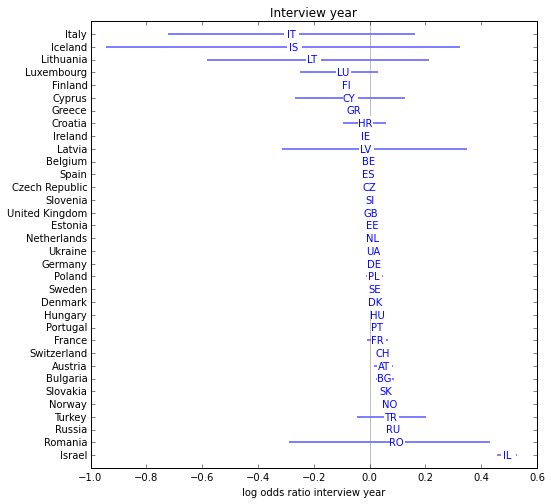

In [470]:
t = extract_vars(country_map, 'inwyr07_f', 'hasrelig_f')
plot_cis(t)
thinkplot.Config(title='Interview year',
                 xlabel='log odds ratio interview year')
save_plot()

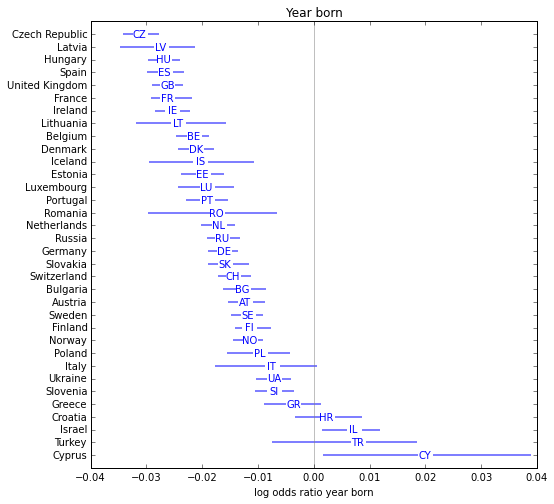

In [471]:
t = extract_vars(country_map, 'yrbrn60_f', 'hasrelig_f')    
plot_cis(t)
thinkplot.Config(title='Year born',
                 xlabel='log odds ratio year born')
save_plot()

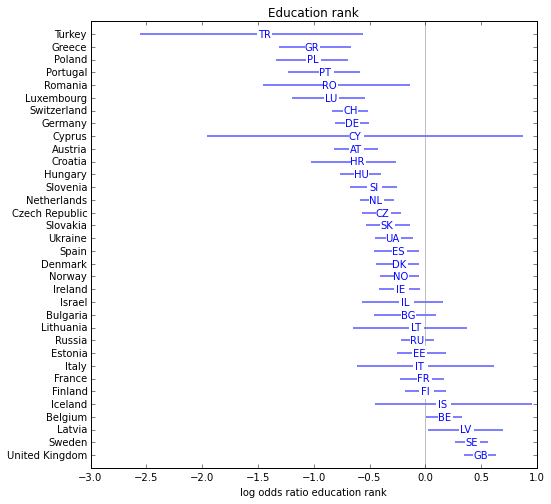

In [472]:
t = extract_vars(country_map, 'edurank_f', 'hasrelig_f')    
plot_cis(t)
thinkplot.Config(title='Education rank',
                 xlabel='log odds ratio education rank')
save_plot()

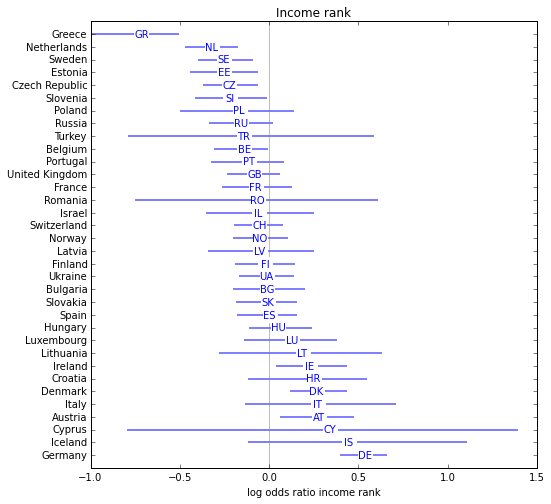

In [473]:
t = extract_vars(country_map, 'hincrank_f', 'hasrelig_f')    
plot_cis(t)
thinkplot.Config(title='Income rank',
                 xlabel='log odds ratio income rank')
save_plot()

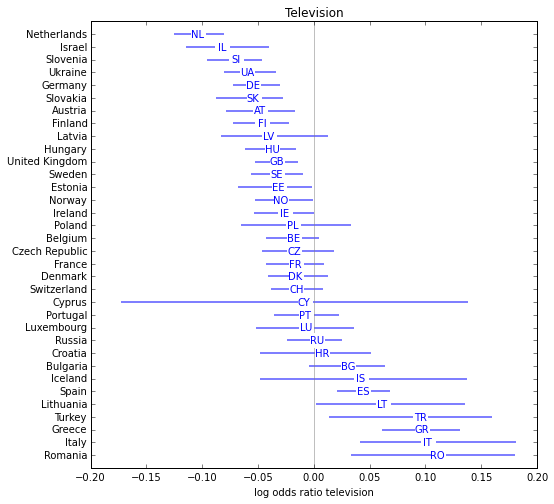

In [474]:
t = extract_vars(country_map, 'tvtot_f', 'hasrelig_f')    
plot_cis(t)
thinkplot.Config(title='Television',
                 xlabel='log odds ratio television')
save_plot()

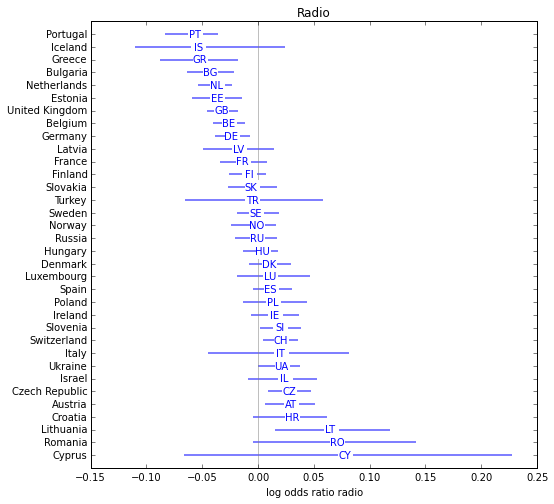

In [475]:
t = extract_vars(country_map, 'rdtot_f', 'hasrelig_f')    
plot_cis(t)
thinkplot.Config(title='Radio',
                 xlabel='log odds ratio radio')
save_plot()

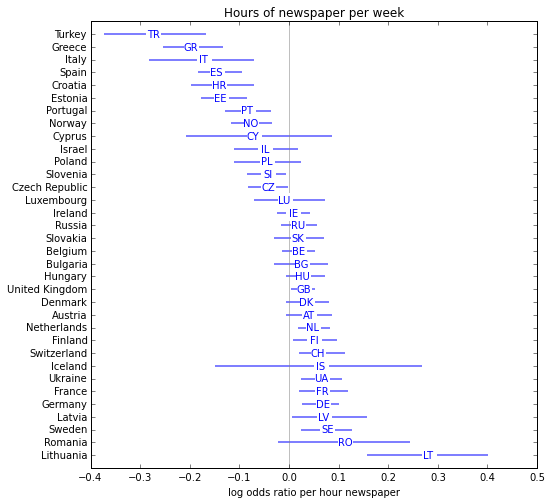

In [476]:
t = extract_vars(country_map, 'nwsptot_f', 'hasrelig_f')    
plot_cis(t)
thinkplot.Config(title='Hours of newspaper per week',
                 xlabel='log odds ratio per hour newspaper')
save_plot()

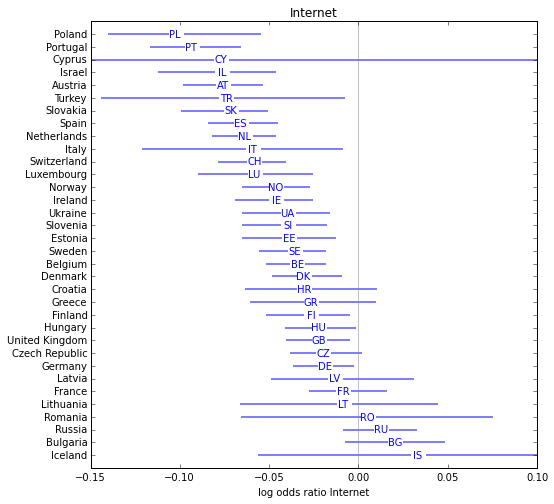

In [477]:
t = extract_vars(country_map, 'netuse_f', 'hasrelig_f')    
plot_cis(t)
thinkplot.Config(title='Internet',
                 xlabel='log odds ratio Internet', 
                 xlim=[-0.15, 0.1])
save_plot()

Make a scatter plot of fraction who have religion versus odds ratio of netuse.

In [478]:
def plot_scatter(t):
    plt.figure(figsize=(8,8))

    codes, names, params, lows, highs, means = zip(*t)

    for param, mean, code in zip(params, means, codes):
        plt.text(param, mean, code, fontsize=10, color='blue', 
                 horizontalalignment='center',
                 verticalalignment='center')
        
    corr = np.corrcoef(params, means)[0][1]
    print(corr)

-0.38248029366


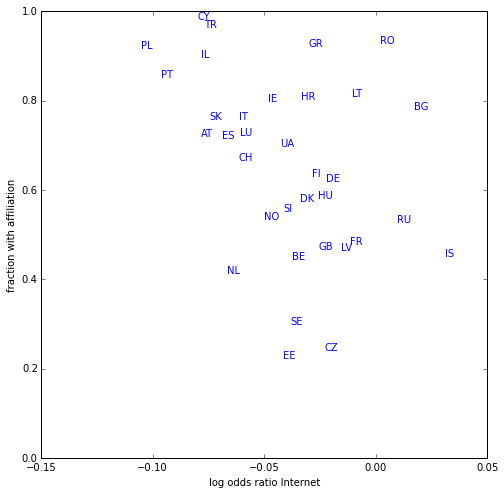

In [479]:
t = extract_vars(country_map, 'netuse_f', 'hasrelig_f')
plot_scatter(t)
thinkplot.Config(title='',
                 xlabel='log odds ratio Internet',
                 ylabel='fraction with affiliation',
                 xlim=[-0.15, 0.05])
save_plot()

Make similar figures for the second model, with degree of religiosity as the dependent variable.

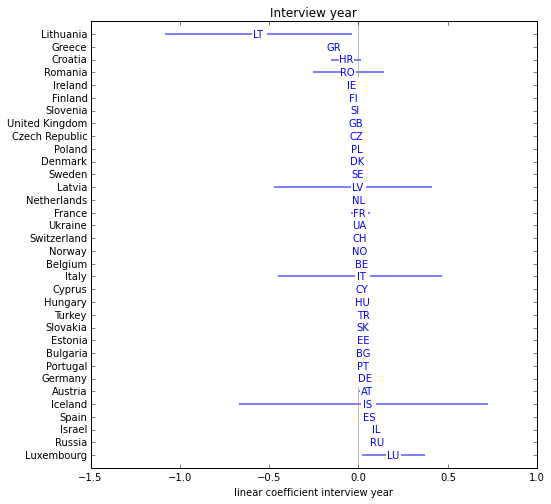

In [480]:
t = extract_vars2(country_map, 'inwyr07_f', 'rlgdgr_f')
plot_cis(t)
thinkplot.Config(title='Interview year',
                 xlabel='linear coefficient interview year')
save_plot()

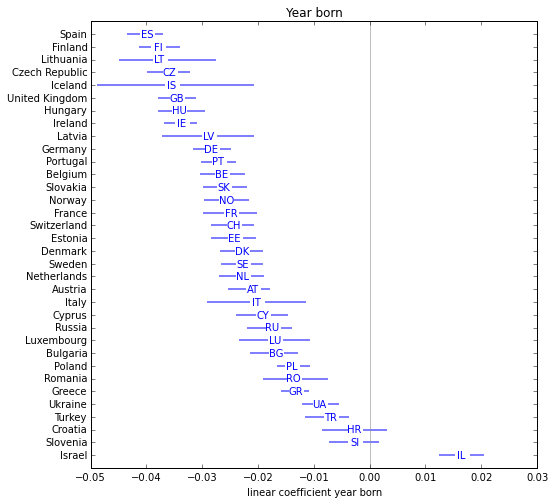

In [481]:
t = extract_vars2(country_map, 'yrbrn60_f', 'rlgdgr_f')
plot_cis(t)
thinkplot.Config(title='Year born',
                 xlabel='linear coefficient year born')
save_plot()

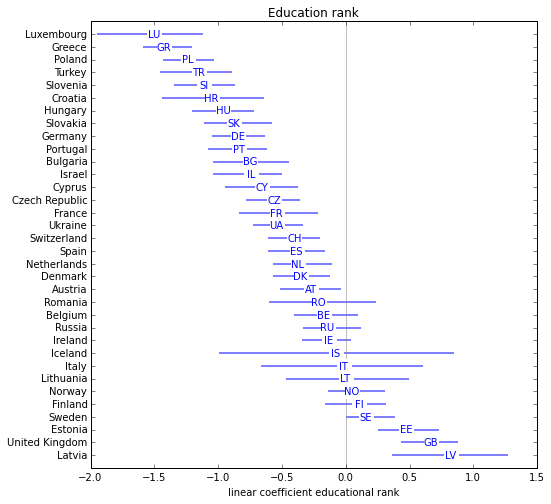

In [482]:
t = extract_vars2(country_map, 'edurank_f', 'rlgdgr_f')
plot_cis(t)
thinkplot.Config(title='Education rank',
                 xlabel='linear coefficient educational rank')
save_plot()

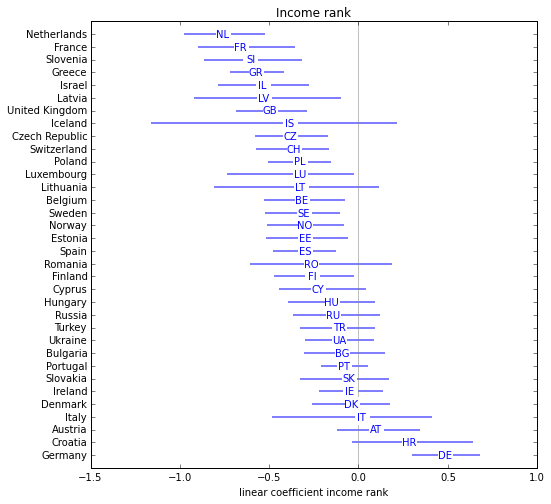

In [483]:
t = extract_vars2(country_map, 'hincrank_f', 'rlgdgr_f')
plot_cis(t)
thinkplot.Config(title='Income rank',
                 xlabel='linear coefficient income rank')
save_plot()

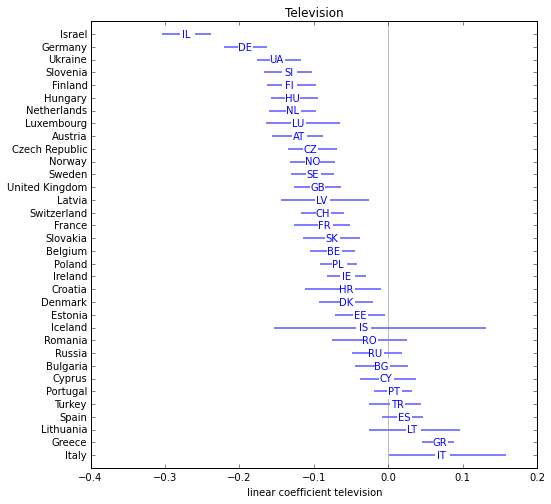

In [484]:
t = extract_vars2(country_map, 'tvtot_f', 'rlgdgr_f')
plot_cis(t)
thinkplot.Config(title='Television',
                 xlabel='linear coefficient television')
save_plot()

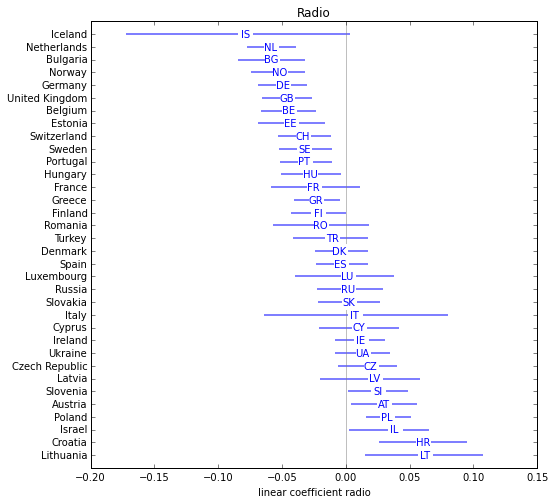

In [485]:
t = extract_vars2(country_map, 'rdtot_f', 'rlgdgr_f')
plot_cis(t)
thinkplot.Config(title='Radio',
                 xlabel='linear coefficient radio')
save_plot()

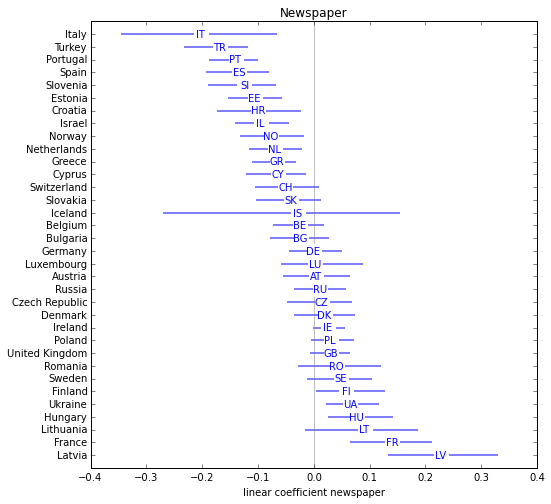

In [486]:
t = extract_vars2(country_map, 'nwsptot_f', 'rlgdgr_f')
plot_cis(t)
thinkplot.Config(title='Newspaper',
                 xlabel='linear coefficient newspaper')
save_plot()

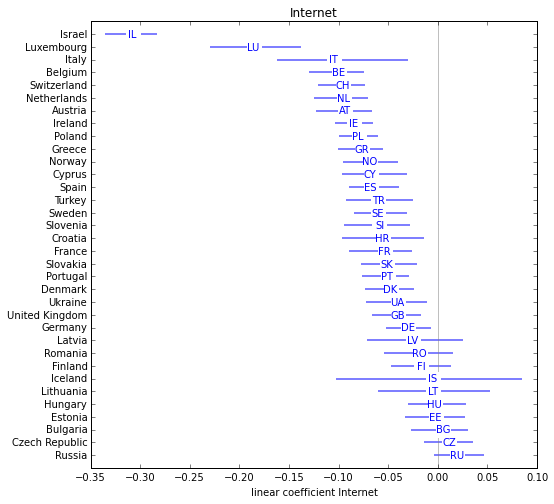

In [487]:
t = extract_vars2(country_map, 'netuse_f', 'rlgdgr_f')
plot_cis(t)
thinkplot.Config(title='Internet',
                 xlabel='linear coefficient Internet')
save_plot()

Here's the scatter plot of effect size on rlgdgr versus mean value of rlgdgr

rlgdgr is on a 0 to 10 scale, so it is mildly astonishing that national means vary as much as they do, from 2.5 to 7. 

-0.156647270319


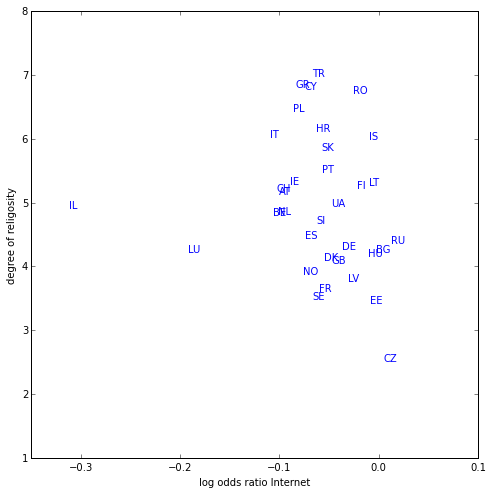

In [488]:
t = extract_vars2(country_map, 'netuse_f', 'rlgdgr_f')
plot_scatter(t)
thinkplot.Config(title='',
                 xlabel='log odds ratio Internet',
                 ylabel='degree of religosity',
                 xlim=[-0.35, 0.1], ylim=[1, 8])
save_plot()

The correlation is dragged down by the outliers; without them, it is more like we saw above.

In [489]:
codes, names, params, lows, highs, means = zip(*t[2:])
corr = np.corrcoef(params, means)[0][1]
print(corr)

-0.361069845352


The following is preliminary work on the next step, showing effect sizes in terms of probability of religious affiliation.

In [490]:
df.head()

,cntry,inwyr,tvtot,tvpol,rdtot,rdpol,nwsptot,nwsppol,netuse,rlgblg,...,hasrelig_f,rlgdgr_f,yrbrn60_f,edurank_f,hincrank_f,tvtot_f,rdtot_f,nwsptot_f,netuse_f,inwyr07_f
0,BE,2002,7,2,6,0,4,4,0,2,...,0,0,-27,0.311326,0.486886,7,6,4,0,-4.587777
1,BE,2002,6,3,1,1,4,1,1,2,...,0,0,-12,0.575953,0.167451,6,1,4,1,-4.644231
2,BE,2002,4,2,7,2,2,2,6,2,...,0,5,5,0.479871,0.691997,4,7,2,6,-5.449223
3,BE,2002,5,0,1,0,1,0,7,2,...,0,2,24,0.407944,0.381305,5,1,1,7,-5.010420
4,BE,2002,2,2,2,2,2,2,6,1,...,1,6,6,0.867955,0.911231,2,2,2,6,-5.010001


In [491]:
grouped = df.groupby('cntry')
group = grouped.get_group('NL')

In [492]:
formula1 = ('hasrelig_f ~ inwyr07_f + yrbrn60_f + '
            'edurank_f + hincrank_f +'
            'tvtot_f + rdtot_f + nwsptot_f + netuse_f')

model = smf.logit(formula1, data=group)    
results = model.fit(disp=False)

mean = group.mean()
low_net = np.percentile(group['netuse_f'], 25)
high_net = np.percentile(group['netuse_f'], 75)

def prob_hasrelig(results, df):
    return results.predict(mean)[0]

print(mean['hasrelig_f'])
print(low_net, high_net)
print(prob_hasrelig(results, mean)) 
mean.netuse_f = low_net
print(prob_hasrelig(results, mean)) 
mean.netuse_f = high_net
print(prob_hasrelig(results, mean)) 

0.427779488759
2.0 7.0
0.424357421451
0.468580999574
0.391422353132
